# <font color = "steelblue"> Hands on - Open Science </font>

### <font color = "limegreen"> Imports </font>

In [11]:
import numpy as np
#------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
#------------------------------------------------------------------------------
mpl.style.reload_library()
mpl.style.use('singleplot')
#------------------------------------------------------------------------------
from iminuit.cost import LeastSquares
from iminuit import Minuit
from ast import literal_eval

In [12]:
"""
Just a copy of my full in12parser.py module ;-)
"""
###############################################################################
### FUNCTIONALITY
def val_to_float(var_val_tuple):
    """
    Used for converison of ("parameter_key", "parameter_value") tuples
    into ("parameter_key", float("parameter_value")).
    """
    try:
        val = float(var_val_tuple[1])
    except:
        val = var_val_tuple[1].strip()
    return var_val_tuple[0].strip(), val

#------------------------------------------------------------------------------

def convertString(s):
    '''
    This function will try to convert a string literal to a number or a bool
    such that '1.0' and '1' will both return 1.

    The point of this is to ensure that '1.0' and '1' return as int(1) and that
    'False' and 'True' are returned as bools not numbers.

    This is useful for generating text that may contain numbers for diff
    purposes.  For example you may want to dump two XML documents to text files
    then do a diff.  In this case you would want <blah value='1.0'/> to match
    <blah value='1'/>.

    The solution for me is to convert the 1.0 to 1 so that diff doesn't see a
    difference.

    If s doesn't evaluate to a literal then s will simply be returned UNLESS the
    literal is a float with no fractional part.  (i.e. 1.0 will become 1)

    If s evaluates to float or a float literal (i.e. '1.1') then a float will be
    returned if and only if the float has no fractional part.

    if s evaluates as a valid literal then the literal will be returned. (e.g.
    '1' will become 1 and 'False' will become False)
    '''


    if isinstance(s, str):
        # It's a string.  Does it represnt a literal?
        #
        try:
            val = literal_eval(s)
        except:
            # s doesn't represnt any sort of literal so no conversion will be
            # done.
            #
            val = s
    else:
        # It's already something other than a string
        #
        val = s

    ##
    # Is the float actually an int? (i.e. is the float 1.0 ?)
    #
    if isinstance(val, float):
        if val.is_integer(): 
            return int(val)

        # It really is a float
        return val

    return val

#------------------------------------------------------------------------------

def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

###############################################################################
### LineParser
class PassParser:
    """
    
    """
    def parse(self, key, *parse_string):
        """
        
        """
        return (key.strip().upper(), " ".join([s.strip() for s in parse_string]))

#------------------------------------------------------------------------------

class InstrParser:
    """
    
    """
    def parse(self, key, *parse_strings):
        """
        
        """
        return ("INSTRUMENT", " ".join([to_strip.strip() for to_strip in parse_strings]))

#------------------------------------------------------------------------------

class FileNrParser:
    """
    
    """
    def parse(self, key, parse_string):
        """
        
        """
        try:
            return ("FILENUMBER", int(parse_string))
        except:
            return ("FILENUMBER", parse_string.strip())

#------------------------------------------------------------------------------

class DateParser:
    """
    
    """
    _months = {"JAN" : "01",
               "FEB" : "02",
               "MAR" : "03",
               "APR" : "04",
               "MAY" : "05",
               "JUN" : "06",
               "JUL" : "07",
               "AUG" : "08",
               "SEP" : "09",
               "OCT" : "10",
               "NOV" : "11",
               "DEC" : "12"
              }

    def parse(self, key, *parse_strings):
        """
        
        """
        datehr, minutes, seconds = [s.strip() for s in parse_strings]
        date, hours = datehr.strip().split(" ")
        y, m, d = date.split("-")[::-1]
        m = self._months[m.upper()]
#        retdict = {"DATE" : "/".join([y, m, d]),
#                   "TIME" : ":".join([hours, minutes, seconds])
#                  }
        retdict = ("DATE-TIME", " ".join(("/".join([y, m, d]), ":".join([hours, minutes, seconds]))))
        return retdict

#------------------------------------------------------------------------------

class PosQEParser:
    """
    
    """
    def parse(self, key, parse_string):
        """
        
        """
        qpos = ("QH", "QK", "QL", "EN", "UN")
        vals = [s.split("=")[1].strip() for s in parse_string.strip().split(", ")]
        return ("POSQE", dict(zip(qpos, vals)))

#------------------------------------------------------------------------------

class ParamParser:
    """
    
    """
    def parse(self, key, parse_strings):
        """
        
        """
        varvals = [vv.strip() for vv in parse_strings.split(",")]
        return (key.strip().upper(), dict([val_to_float(vv.split("=")) for vv in varvals]))

#------------------------------------------------------------------------------

class CommandParser:
    """
    
    """
    _idx_allocator = {
        0 : "device_state",
        1 : "step_indicator",
        2 : "step",
        3 : "numpoints_indicator",
        4 : "numpoints",
        5 : "counter_device",
        6 : "counter_threshold"
    }

    def parse(self, key, parse_string):
        """
        
        """
        bits = parse_string.strip().split(" ")
        
        retdict = {
            "command" : bits[0],
            "device" : bits[1],
            "device_state" : [],
            "step_indicator" : None,
            "step" : [],
            "numpoints_indicator" : None,
            "numpoints" : 0,
            "counter_device" : None,
            "counter_threshold" : 0
        }

        a = 0
        for idx, element in enumerate(bits[2:]):
            temp = convertString(element)
            if isinstance(temp, str):
                a += 1
                retdict[self._idx_allocator[a]] = temp
                a += 1
            elif isinstance(temp, int) or isinstance(temp, float):
                if isinstance(retdict[self._idx_allocator[a]], int):
                    retdict[self._idx_allocator[a]] = temp
                elif isinstance(retdict[self._idx_allocator[a]], list):
                    retdict[self._idx_allocator[a]].append(temp)
        return ("COMMAND", retdict)

#------------------------------------------------------------------------------

class DataDescrParser:
    
    def parse(self, data_descr_line):
        return [dev for dev in data_descr_line.split(" ") if (dev != "" and dev != "\n")]

###############################################################################
### IN12Parser

class IN12Parser:
    """
    
    """
    _parsers = {
        "INSTR" : InstrParser(),
        "EXPNO" : PassParser(),
        "USER_" : PassParser(),
        "LOCAL" : PassParser(),
        "FILE_" : FileNrParser(),
        "DATE_" : DateParser(),
        "TITLE" : PassParser(),
        "TYPE_" : PassParser(),
        "COMND" : CommandParser(),
#        "POSQE" : PosQEParser(),
        "POSQE" : ParamParser(),
        "CURVE" : PassParser(),
        "STEPS" : ParamParser(),
        "PARAM" : ParamParser(),
        "VARIA" : ParamParser(),
        "ZEROS" : ParamParser(),
        "ELSE_" : PassParser(),
        "DATAD" : DataDescrParser()
    }
    
    def _get_neutron_data(self, filepath, headerlength=0):
        return np.genfromtxt(filepath, skip_header=headerlength)

    def parse(self, filepath):
        """
        
        """
        meta_dict = {}
        at_data = False
        linecounter = 0     

        with open(filepath, "r") as f:
            # read lines as lon as "DATA_" specifier in file is not reached
            while not at_data:
                linecounter += 1
                line = f.readline()
                splitted = line.split(":")
                key = splitted[0]
                # skip as long as line does not start with 5 char keyword
                if len(key) != 5:
                    continue
                # if line starts with known keyword -> parse accordingly
                elif key in self._parsers.keys():
                    retkey, retdict = self._parsers[key].parse(*splitted)
                    if retkey in meta_dict.keys():
                        meta_dict[key].update(retdict)
                    else:
                        meta_dict[key] = retdict
                elif key == "DATA_":
                    data_descr_line = f.readline()
                    device_names = DataDescrParser().parse(data_descr_line)
                    at_data = True
        _data = self._get_neutron_data(filepath, linecounter + 1)
        return MetaDataContainer(meta_dict), NeutronDataContainer(_data, colnames=device_names, units=[""] * len(device_names))
        

#------------------------------------------------------------------------------

def update(d, key, items):
    if key in d.keys():
        d[key].update(items)
    return d

###############################################################################
### DataContainer

class MetaDataContainer:
    """
    
    """
    def __init__(self, meta_dict):
        """
        Parameters
        ----------
        meta_dict       :   dict
            dictionary containing the parameter values from parsing an
            (IN12) ILL ASCII data file
        """
        self.metadata = meta_dict

    def get(self, key):
        """
        Parameters
        ----------
        key             :   str
            key of the querried parameter
        """
        if key in self.metadata.keys():
            return self.metadata[key]
        else:
            for mkey in self.metadata.keys():
                try:
                    return self.metadata[mkey][key]
                except:
                    pass
#                if key in self.metadata[mkey].keys():
#                    return self.metadata[mkey][key]
        return {key : None}

#------------------------------------------------------------------------------

class NeutronDataContainer:
    """
    
    """
    def __init__(self, neutron_data, colnames=None, units=None):
        """
        Parameters
        ----------
        neutron_data    :   ndarray
            array containing the data of a TAS instrument scan
        colnames        :   list
            list of names describing columns in neutron_data
        units           :   list
            list of unit description sting for each name in colnames
        """

        self.neutron_data = neutron_data
        self.colnames = colnames
        self.units = units

    def get(self, idxs=[], colnames=[], only_data=True):
        """
        Parameters
        ----------
        idx             :   list[int]
            index value(s) specifying the columns of the data to be returned
        colname         :   list[str]
            column name as key specifying the columns of the data to be returned
            
        Note
        ----
        NeutronDataContainer.get() returns everything
        """
        try:
            assert isinstance(idxs, list)
            assert isinstance(colnames, list)
        except AssertionError:
            raise AssertionError(f"idx = {idxs} or colnames = {colnames} is not a list.")
        
        if not (idxs or colnames):
#            print("OPTION 1")
            if only_data:
                return self.neutron_data
            else:
                return self.neutron_data, self.colnames, self.units
        
        elif not idxs and colnames:
#            print("OPTION 2")
            idxs = [self.colnames.index(cn) for cn in colnames]
            if only_data:
                return self.neutron_data[:, idxs]
            else:
                return self.neutron_data[:, idxs], colnames, [self.units[idx] for idx in idxs]

        elif idxs and not colnames:
#            print("OPTION 3")
            if only_data:
                return self.neutron_data[:, idxs]
            else:
                return self.neutron_data[:, idxs], [self.colnames[idx] for idx in idxs], [self.units[idx] for idx in idxs]

        elif idxs and colnames:
#            print("OPTION 4")
            colidxs = [self.colnames.index(cn) for cn in colnames]
            idxs = set(colidxs).union(set(idxs))
            idxs = list(idxs)
            if only_data:
                return self.neutron_data[:, idxs]
            else:
                return self.neutron_data[:, idxs], [self.colnames[idx] for idx in idxs], [self.units[idx] for idx in idxs]
        else:
            print("This should not happen!")
            raise ValueError("What the f**k is happening")

###############################################################################
                   
if __name__ == "__main__":
    pass

### <font color = "limegreen"> Additional </font>

#### <font color = "lightgreen"> Utils </font>

In [13]:
def params_to_dict(minuitresult, noerrors=True):
    retdict = {}
    for i in minuitresult:
        if noerrors:
            retdict[i.name] = i.value
        else:
            retdict[i.name] = i.value, i.error
    return retdict

#### <font color = "lightgreen"> Math funcitons </font>

In [14]:
def line(x, m, b):
    return m*x + b

In [21]:
def gaussian_function(x, amp, x0, sig, bckg):
    """
    A customizable gaussian peak
    """

    return amp * 1.0/np.sqrt(2 * np.pi * sig * sig) * np.exp(- 0.5 * ((x - x0)/sig)**2) + bckg

In [22]:
def constantE_model_sloped_bckg(x, amp1, x01, sigma1, amp2, x02, sigma2, m, b):
    return gaussian_function(x, amp1, x01, sigma1, 0.0) + gaussian_function(x, amp2, x02, sigma2, 0.0) + line(x, m, b)

#### <font color = "lightgreen"> Fitting </font>

In [23]:
class SymmetricExcitationsLeastSquares:
    def __init__(self, x, y, yerr, inflectionpoint):
        self.x = np.array(x)
        self.y = np.array(y)
        self.yerr = np.array(yerr)
        self.inflectionpoint = inflectionpoint
    def __call__(self, dx0, amp1, sigma1, amp2, sigma2, m, b):
        ym = line(self.x, m, b) + gaussian_function(self.x, amp1, self.inflectionpoint - dx0, sigma1, 0.0) + gaussian_function(self.x, amp2, self.inflectionpoint + dx0, sigma2, 0.0)
        return np.sum(np.power((self.y - ym) / self.yerr, 2))
    def calc(self, x, dx0, amp1, sigma1, amp2, sigma2, m, b):
        return line(x, m, b) + gaussian_function(x, amp1, self.inflectionpoint - dx0, sigma1, 0.0) + gaussian_function(x, amp2, self.inflectionpoint + dx0, sigma2, 0.0)

##  <font color = "green"> IN3 mini school </font>

In [24]:
parser = IN12Parser()

In [25]:
m, nd = parser.parse("/home/lbeddric/Downloads/084905")
#------------------------------------------------------------------------------
qh = nd.get(colnames=["QH"]).flatten()
qk = nd.get(colnames=["QK"]).flatten()
ql = nd.get(colnames=["QL"]).flatten()
q = nd.get(colnames=["QL"]).flatten()

#q = np.sqrt((qh + 2.0)**2 + (qk - 2.0)**2 + ql**2)

qfit = np.linspace(q[0], q[-1], 101)
cnts = nd.get(colnames=["CNTS"]).flatten()

In [26]:
# FIT PARAMATERS
lsq = SymmetricExcitationsLeastSquares(q,
                                       cnts,
                                       cnts**0.5,
                                       inflectionpoint=0.0
                                      )

iminuit_param_dict = dict(dx0=0.1,
                              amp1=1200.,
                              sigma1=0.04,
                              amp2=900,
                              sigma2=0.04,
                              m=0.0,
                              b=100.0,
                             )

total_iminuit_dict = dict(limit_dx0=(0.0, None),
                              limit_amp1=(0.0, None),
                              limit_amp2=(0.0, None),
                              limit_sigma1=(0.0, 0.08),
                              limit_sigma2=(0.0, 0.08),
                              fix_m=True,
                              fix_b=False
                             )

total_iminuit_dict.update(iminuit_param_dict)
minuit = Minuit(lsq, errordef=1, **total_iminuit_dict)
fmin, res = minuit.migrad(ncall=10000)
print(fmin)
print(res)

------------------------------------------------------------------
| FCN = 658.6                   |     Ncalls=884 (884 total)     |
| EDM = 1.8e-05 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
--------------------------------------------------------------------------------------------
|   | Name   |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------

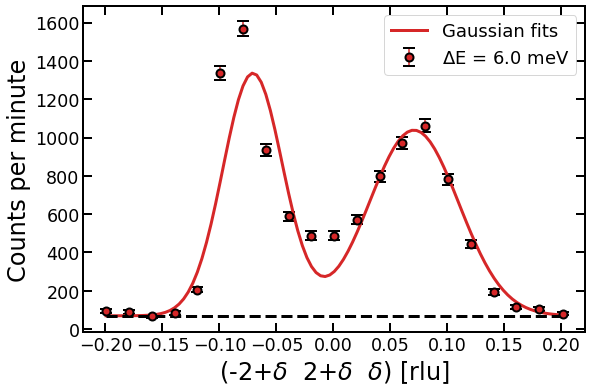

In [27]:
plt.figure(figsize=(9.0, 6.0))
plt.errorbar(q,
             cnts,
             np.sqrt(cnts),
             marker="o",
             color="C3",
             ls="",
#             label="$\Delta$E = 6.0 meV\nk$_f$ = 1.1$\,\AA^{-1}$",
             label="$\Delta$E = 6.0 meV"
            )
### FOR SymmetricExcistationsLeastSquares
plt.plot(qfit,
         lsq.calc(qfit, **params_to_dict(res)),
         lw=3.0,
         ls="-",
         color="C3",
#         label=f"Q$_{'{K1}'}$ = {1 - res[0].value:.3f} $\pm$ {res[0].error:.3f}\nQ$_{'{K2}'}$ = {1 + res[0].value:.3f} $\pm$ {res[0].error:.3f}"
         label=f"Gaussian fits"
        )
plt.plot(qfit, line(qfit, res[5].value, res[6].value), lw=3.0, ls="--", color="k")

#plt.text(0.74, 1850, "Files:\n--------\n- 057536", fontsize=14)
#plt.text(1.15, 1850, f"$\chi^2_N = {(fmin.fval / 21):.3f}$", fontsize=18)
plt.xlabel("(-2+$\delta$  2+$\delta$  $\delta$) [rlu]", fontsize=24)
plt.ylabel("Counts per minute", fontsize=24)
#plt.ylim(ymax=2300, ymin=1550)
plt.legend(loc="upper right", fontsize=18)
plt.tick_params("both", which="minor" , length=False)
#plt.savefig("/home/lbeddric/Desktop/mini-school-si-cescan.png", dpi=300, bbox_inches="tight")